In this notebook, we'll implement a L-Layer deep model on MNIST dataset using Keras. The dataset contains tens of thousands of scanned images of handwritten digits, together with their correct classifications.

In [1]:
# Importing relevant libraries
import numpy as np
import pandas as pd
import pickle
import gzip
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets
import scipy

from PIL import Image
from scipy import ndimage

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras import regularizers

np.random.seed(7)

%matplotlib inline

The MNIST dataset we use here is "mnist.pkl.gz" which is divided into training, validation and test data. The following function "load_data()" unpacks the file and eztracts the training, validation and test data.

In [2]:
def load_data():
    f = gzip.open("mnist.pkl.gz", "rb")
    f.seek(0)
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

In [3]:
# Let's see how the dataset looks
training_data, validation_data, test_data = load_data()

In [4]:
training_data

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([5, 0, 4, ..., 8, 4, 8], dtype=int64))

In [5]:
print("The feature dataset is:" + str(training_data[0]))
print("The target dataset is:" + str(training_data[1]))
print("The number of examples in the training dataset is:" + str(len(training_data[0])))
print("The number of points in a single input is:" + str(len(training_data[0][1])))

The feature dataset is:[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The target dataset is:[5 0 4 ... 8 4 8]
The number of examples in the training dataset is:50000
The number of points in a single input is:784


In [6]:
# The target variable is converted to a one hot matrix. We use the function one_hot to convert the target dataset to one hot encoding
def one_hot(j):
    n = j.shape[0]
    new_array = np.zeros((10,n))
    index = 0
    for res in j:
        new_array[res][index] = 1.0
        index += 1
    return new_array

In [7]:
data = np.array([0,1,2,3,4,5,6,7,8,9])

In [8]:
one_hot(data)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [9]:
def data_wrapper():
    tr_d, va_d, te_d = load_data()
    
    training_inputs = np.array(tr_d[0][:]).T
    training_results = np.array(tr_d[1][:])
    train_set_y = one_hot(training_results)
    
    validation_inputs = np.array(va_d[0][:]).T
    validation_results = np.array(va_d[1][:])
    validation_set_y = one_hot(validation_results)
    
    test_inputs = np.array(te_d[0][:]).T
    test_results = np.array(te_d[1][:])
    test_set_y = one_hot(test_results)
    
    return (training_inputs, train_set_y, validation_inputs, validation_set_y)

In [10]:
train_set_x, train_set_y, test_set_x, test_set_y = data_wrapper()

For implementing in Keras, the input training and input dataset are supposed to have shape (m,n) where m is the number of training samples and n is the number of parts in a single input.
Hence, let's create the desired dataset shapes by taking the transpose.

In [11]:
train_set_x = train_set_x.T
train_set_y = train_set_y.T
test_set_x = test_set_x.T
test_set_y = test_set_y.T

In [12]:
# Shape of the datasets
print("train_set_x shape:" + str(train_set_x.shape))
print("train_set_y shape:" + str(train_set_y.shape))
print("test_set_x shape:" + str(test_set_x.shape))
print("test_set_y shape:" + str(test_set_y.shape))

train_set_x shape:(50000, 784)
train_set_y shape:(50000, 10)
test_set_x shape:(10000, 784)
test_set_y shape:(10000, 10)


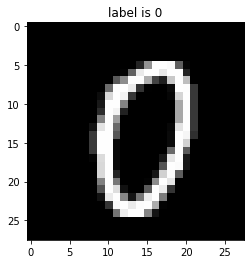

In [13]:
# Visualising the dataset
index = 1000
k = train_set_x[index,:]
k = k.reshape((28,28))
plt.title("label is {label}".format(label=training_data[1][index]))
plt.imshow(k,cmap = "gray");

Keras is a framework. So, to implement a neural network model in Keras, we first create an instance of Sequential().

The Sequential model is a linear stack of layers. We then keep adding Dense layers that are fully connected layers as we desire.

We can also add regularization.

In [14]:
# Creating the model
nn_model = Sequential()
nn_model.add(Dense(35, input_dim = 784, activation = "relu"))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(21, activation = "relu"))
nn_model.add(Dense(10, activation = "softmax"))

Before we run the model on the training datasets, we compile the model in which we define various things like loss function, the optimizer and the evaluation metric.

In [15]:
nn_model.compile(loss= "categorical_crossentropy", optimizer= "adam", metrics=["accuracy"])

Now, to fit the model on the training input and training target dataset, we run the following command using a minibatch of size 10 and 10 epochs.

In [16]:
nn_model.fit(train_set_x, train_set_y, epochs = 10, batch_size = 10)

Epoch 1/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.5276 - accuracy: 0.8365
Epoch 2/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.3196 - accuracy: 0.9028
Epoch 3/10
5000/5000 [==============================] - 5s 1ms/step - loss: 0.2814 - accuracy: 0.9131
Epoch 4/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.2586 - accuracy: 0.9204
Epoch 5/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.2386 - accuracy: 0.9260
Epoch 6/10
5000/5000 [==============================] - 5s 1ms/step - loss: 0.2336 - accuracy: 0.9261
Epoch 7/10
5000/5000 [==============================] - 5s 1ms/step - loss: 0.2246 - accuracy: 0.9297
Epoch 8/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.2133 - accuracy: 0.9326
Epoch 9/10
5000/5000 [==============================] - 5s 1ms/step - loss: 0.2076 - accuracy: 0.9348
Epoch 10/10
5000/5000 [==============================] - 6s 1ms/step - loss: 0.206

In [17]:
scores_train = nn_model.evaluate(train_set_x, train_set_y)
print("\n%s: %.2f%%" % (nn_model.metrics_names[1], scores_train[1]*100))

1563/1563 [==============================] - 2s 903us/step - loss: 0.1038 - accuracy: 0.9694

accuracy: 96.94%


`Inference:` We can see that the model has 97% accuracy.

In [18]:
# Now let's make the predictions on the test dataset
predictions = nn_model.predict(test_set_x)
predictions = np.argmax(predictions, axis=1)
predictions

array([3, 8, 6, ..., 5, 6, 8], dtype=int64)

In [19]:
scores_test = nn_model.evaluate(test_set_x, test_set_y)
print("\n%s: %.2f%%" % (nn_model.metrics_names[1], scores_test[1]*100))

313/313 [==============================] - 0s 944us/step - loss: 0.1338 - accuracy: 0.9623

accuracy: 96.23%


`Inference:` We can see that the model has ~96% accuracy on the training dataset.